
# 03 — Graph Sanity Checks & Overview
# 
#### This notebook loads `hetero_graph.pt` from `data/processed/`,
#### summarizes node/edge statistics, degree distributions, and
#### basic structural properties (e.g., connected components).

In [1]:
import os
from pathlib import Path

import torch
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.data import HeteroData

# Paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
GRAPH_PATH = DATA_PROCESSED / "hetero_graph.pt"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("GRAPH_PATH:", GRAPH_PATH)

# Load hetero graph
obj = torch.load(GRAPH_PATH, weights_only=False)
data: HeteroData = obj["data"]
node_maps = obj["node_maps"]

data


PROJECT_ROOT: /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn
GRAPH_PATH: /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/processed/hetero_graph.pt


HeteroData(
  disease={
    num_nodes=58,
    x=[58, 1],
  },
  gene={
    num_nodes=14779,
    x=[14779, 1],
  },
  variant={
    num_nodes=285747,
    x=[285747, 1],
  },
  gene_fusion={
    num_nodes=4266,
    x=[4266, 1],
  },
  chrom_rearr={
    num_nodes=1993,
    x=[1993, 1],
  },
  pathway={
    num_nodes=1488,
    x=[1488, 1],
  },
  biomarker={
    num_nodes=24,
    x=[24, 1],
  },
  chemical={
    num_nodes=160,
    x=[160, 1],
  },
  evidence={
    num_nodes=144,
    x=[144, 1],
  },
  city={
    num_nodes=368,
    x=[368, 1],
  },
  demographic_group={
    num_nodes=204,
    x=[204, 1],
  },
  (disease, assoc_gene, gene)={ edge_index=[2, 82461] },
  (disease, assoc_gene_fusion, gene_fusion)={ edge_index=[2, 4289] },
  (disease, assoc_chrom_rearr, chrom_rearr)={ edge_index=[2, 2309] },
  (disease, assoc_variant, variant)={ edge_index=[2, 500000] },
  (disease, assoc_pathway, pathway)={ edge_index=[2, 168] },
  (gene, participates_in, pathway)={ edge_index=[2, 50651] },
  (d

# Node & Edge statistics overview


In [2]:
# Node counts
node_stats = []
for nt in data.node_types:
    node_stats.append({
        "node_type": nt,
        "num_nodes": data[nt].num_nodes
    })
node_stats_df = pd.DataFrame(node_stats).sort_values("node_type").reset_index(drop=True)
display(node_stats_df)

# Edge counts
edge_stats = []
for et in data.edge_types:
    edge_index = data[et].edge_index
    edge_stats.append({
        "edge_type": str(et),
        "src_type": et[0],
        "relation": et[1],
        "dst_type": et[2],
        "num_edges": edge_index.shape[1],
    })
edge_stats_df = pd.DataFrame(edge_stats).sort_values("num_edges", ascending=False).reset_index(drop=True)
display(edge_stats_df)


,node_type,num_nodes
0,biomarker,24
1,chemical,160
2,chrom_rearr,1993
3,city,368
4,demographic_group,204
5,disease,58
6,evidence,144
7,gene,14779
8,gene_fusion,4266
9,pathway,1488


,edge_type,src_type,relation,dst_type,num_edges
0,"('disease', 'assoc_variant', 'variant')",disease,assoc_variant,variant,500000
1,"('disease', 'assoc_gene', 'gene')",disease,assoc_gene,gene,82461
2,"('gene', 'participates_in', 'pathway')",gene,participates_in,pathway,50651
3,"('disease', 'assoc_gene_fusion', 'gene_fusion')",disease,assoc_gene_fusion,gene_fusion,4289
4,"('disease', 'assoc_chrom_rearr', 'chrom_rearr')",disease,assoc_chrom_rearr,chrom_rearr,2309
5,"('chemical', 'measured_in', 'city')",chemical,measured_in,city,373
6,"('disease', 'has_demographic_stats', 'demograp...",disease,has_demographic_stats,demographic_group,204
7,"('chemical', 'has_evidence', 'evidence')",chemical,has_evidence,evidence,198
8,"('disease', 'assoc_pathway', 'pathway')",disease,assoc_pathway,pathway,168
9,"('disease', 'assoc_biomarker', 'biomarker')",disease,assoc_biomarker,biomarker,24


# Degree per node type (aggregated over all relations)


In [3]:
import torch

# Create degree tensors initialized to zero for each node type
degrees = {
    nt: torch.zeros(data[nt].num_nodes, dtype=torch.long)
    for nt in data.node_types
}

# Aggregate degrees across all relations (both src and dst)
for (src, rel, dst) in data.edge_types:
    edge_index = data[(src, rel, dst)].edge_index

    # src nodes degree++
    src_deg = torch.bincount(edge_index[0], minlength=data[src].num_nodes)
    degrees[src] += src_deg

    # dst nodes degree++
    dst_deg = torch.bincount(edge_index[1], minlength=data[dst].num_nodes)
    degrees[dst] += dst_deg

# Summarize degree distributions
rows = []
for nt, deg in degrees.items():
    deg_np = deg.numpy()
    rows.append({
        "node_type": nt,
        "num_nodes": len(deg_np),
        "deg_min": int(deg_np.min()) if len(deg_np) > 0 else 0,
        "deg_max": int(deg_np.max()) if len(deg_np) > 0 else 0,
        "deg_mean": float(deg_np.mean()) if len(deg_np) > 0 else 0.0,
        "deg_median": float(pd.Series(deg_np).median()) if len(deg_np) > 0 else 0.0,
        "deg_zero": int((deg_np == 0).sum()),  # isolierte Nodes dieses Typs
    })

degree_stats_df = pd.DataFrame(rows).sort_values("node_type").reset_index(drop=True)
display(degree_stats_df)


,node_type,num_nodes,deg_min,deg_max,deg_mean,deg_median,deg_zero
0,biomarker,24,1,1,1.000000,1.0,0
1,chemical,160,1,373,3.568750,1.0,0
2,chrom_rearr,1993,1,2,1.158555,1.0,0
3,city,368,1,2,1.013587,1.0,0
4,demographic_group,204,1,1,1.000000,1.0,0
5,disease,58,1,190301,10163.017241,342.0,0
6,evidence,144,1,44,1.375000,1.0,0
7,gene,14779,0,237,9.006834,7.0,989
8,gene_fusion,4266,1,2,1.005391,1.0,0
9,pathway,1488,1,444,34.152554,21.0,0


# Degree histograms for selected node types


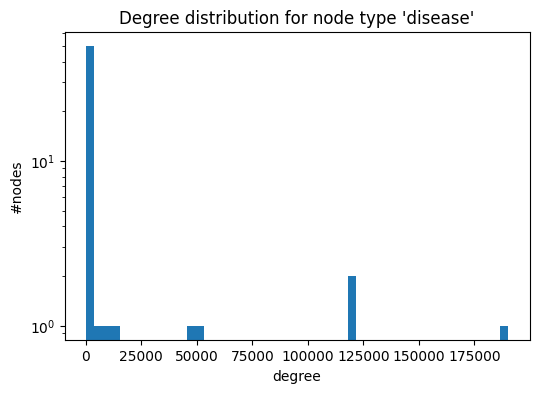

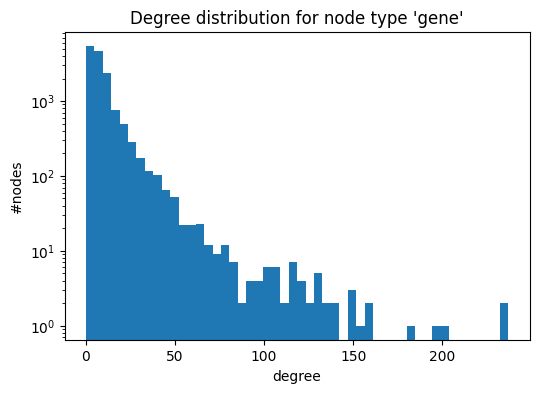

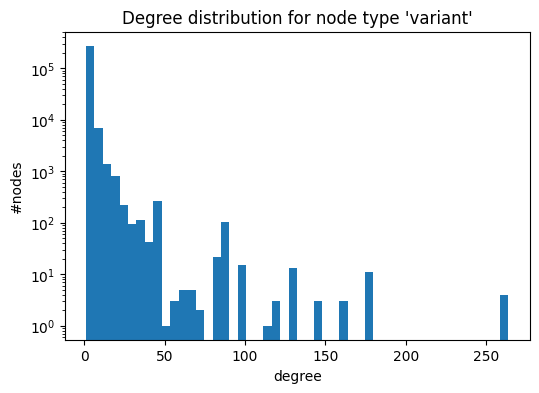

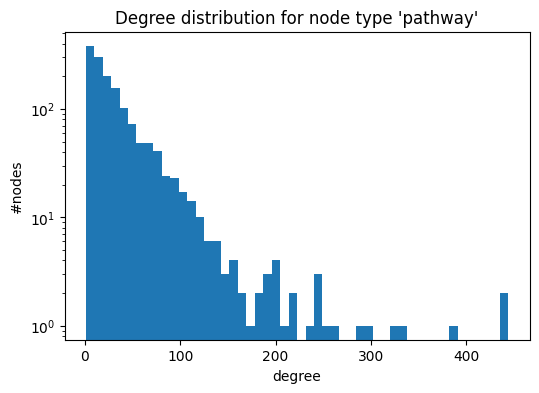

In [4]:
def plot_degree_hist(node_type, log_scale=True, max_deg=None):
    deg = degrees[node_type].numpy()
    if max_deg is not None:
        deg = deg[deg <= max_deg]

    plt.figure(figsize=(6, 4))
    plt.hist(deg, bins=50)
    plt.title(f"Degree distribution for node type '{node_type}'")
    plt.xlabel("degree")
    plt.ylabel("#nodes")
    if log_scale:
        plt.yscale("log")
    plt.show()

# Example: disease, gene, variant, pathway
for nt in ["disease", "gene", "variant", "pathway"]:
    if nt in degrees:
        plot_degree_hist(nt, log_scale=True)


# Connected components (using NetworkX on homogeneous graph)


In [5]:
from torch_geometric.data import HeteroData

# to_homogeneous flacht alle Knoten auf einen gemeinsamen Indexraum ab
homo = data.to_homogeneous()
edge_index = homo.edge_index.cpu().numpy()
num_nodes = homo.num_nodes

print("Homogeneous graph:")
print("  num_nodes:", num_nodes)
print("  num_edges:", edge_index.shape[1])

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(zip(edge_index[0], edge_index[1]))

num_components = nx.number_connected_components(G)
components = sorted(nx.connected_components(G), key=len, reverse=True)

print("Number of connected components:", num_components)
print("Size of largest components:")
for i, comp in enumerate(components[:5]):
    print(f"  Component {i}: {len(comp)} nodes")

# Optional: Anteil der Knoten in der größten Komponente
largest_comp_size = len(components[0])
print("Fraction of nodes in largest component:", largest_comp_size / num_nodes)


Homogeneous graph:
  num_nodes: 309231
  num_edges: 640677
Number of connected components: 1102
Size of largest components:
  Component 0: 307570 nodes
  Component 1: 369 nodes
  Component 2: 77 nodes
  Component 3: 4 nodes
  Component 4: 3 nodes
Fraction of nodes in largest component: 0.9946286109736734


# Inspect neighbors of a given disease node (by local index)


In [6]:
# choose a disease index (0..57)
d_idx = 0

print(f"Inspecting neighbors of disease[{d_idx}]")
# Wir brauchen die externe Disease ID:
inv_disease_map = {v: k for k, v in node_maps["disease"].items()}
disease_cui = inv_disease_map.get(d_idx, None)
print("  DiseaseCui:", disease_cui)

neighbors_summary = {}

for (src, rel, dst) in data.edge_types:
    edge_index = data[(src, rel, dst)].edge_index

    # outgoing from disease
    if src == "disease":
        mask = (edge_index[0] == d_idx)
        nb_indices = edge_index[1][mask].tolist()
        neighbors_summary[(src, rel, dst)] = len(nb_indices)

        if len(nb_indices) > 0:
            print(f"\nRelation (disease -[{rel}]-> {dst}): {len(nb_indices)} neighbors")
            # show up to 10 neighbors with external IDs
            nb_ids = []
            inv_map = {v: k for k, v in node_maps[dst].items()}
            for i in nb_indices[:10]:
                nb_ids.append(inv_map.get(int(i), None))
            print("  Example neighbor IDs:", nb_ids)

    # incoming to disease
    if dst == "disease":
        mask = (edge_index[1] == d_idx)
        nb_indices = edge_index[0][mask].tolist()
        neighbors_summary[(src, rel, dst)] = neighbors_summary.get((src, rel, dst), 0) + len(nb_indices)

        if len(nb_indices) > 0:
            print(f"\nRelation ({src} -[{rel}]-> disease): {len(nb_indices)} neighbors")
            inv_map = {v: k for k, v in node_maps[src].items()}
            nb_ids = [inv_map.get(int(i), None) for i in nb_indices[:10]]
            print("  Example neighbor IDs:", nb_ids)


Inspecting neighbors of disease[0]
  DiseaseCui: C0007120

Relation (disease -[assoc_gene]-> gene): 490 neighbors
  Example neighbor IDs: ['ncbigene:10298', 'ncbigene:208', 'ncbigene:4921', 'ncbigene:6794', 'ncbigene:92335', 'ncbigene:6597', 'ncbigene:2051', 'ncbigene:140803', 'ncbigene:1956', 'ncbigene:2580']

Relation (disease -[assoc_variant]-> variant): 2688 neighbors
  Example neighbor IDs: ['COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017', 'COSM6470017']


# Optional: 1-hop ego graph visualization around disease[0]


Ego graph nodes: 2332
Ego graph edges: 2331


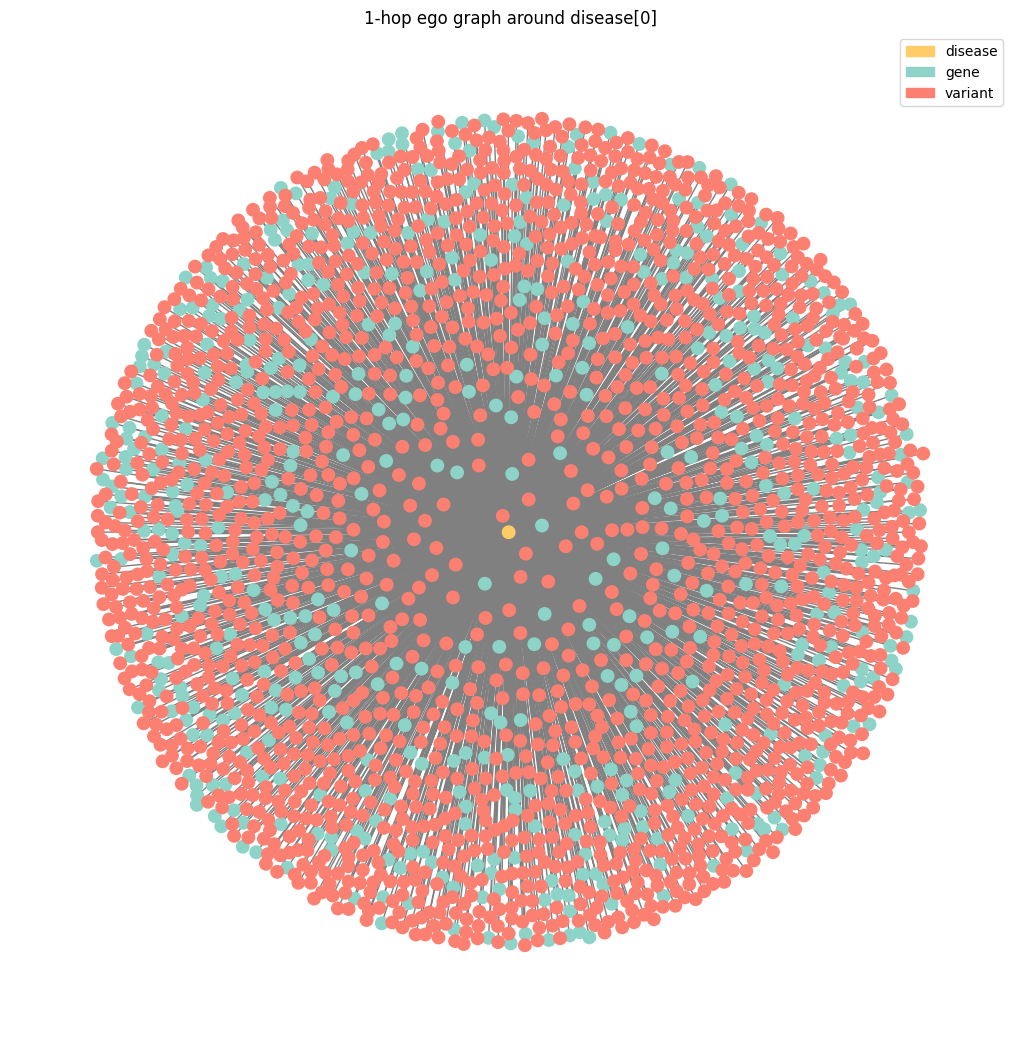

In [7]:
from collections import defaultdict

d_idx = 0

# Build a small NetworkX ego-graph based on 1-hop neighbors
G_ego = nx.Graph()
G_ego.add_node(("disease", d_idx), ntype="disease")

for (src, rel, dst) in data.edge_types:
    edge_index = data[(src, rel, dst)].edge_index

    # disease as source
    if src == "disease":
        mask = (edge_index[0] == d_idx)
        for nb in edge_index[1][mask].tolist():
            nb = int(nb)
            G_ego.add_node((dst, nb), ntype=dst)
            G_ego.add_edge(("disease", d_idx), (dst, nb), rel=rel)

    # disease as target (falls es so etwas gibt)
    if dst == "disease":
        mask = (edge_index[1] == d_idx)
        for nb in edge_index[0][mask].tolist():
            nb = int(nb)
            G_ego.add_node((src, nb), ntype=src)
            G_ego.add_edge((src, nb), ("disease", d_idx), rel=rel)

print("Ego graph nodes:", G_ego.number_of_nodes())
print("Ego graph edges:", G_ego.number_of_edges())

# Map Node-Typen auf Farben
type_colors = {
    "disease": "#ffcc66",
    "gene": "#8dd3c7",
    "variant": "#fb8072",
    "gene_fusion": "#80b1d3",
    "chrom_rearr": "#fdb462",
    "pathway": "#b3de69",
    "biomarker": "#fccde5",
    "chemical": "#d9d9d9",
    "evidence": "#bc80bd",
    "city": "#ccebc5",
    "demographic_group": "#ffffb3",
}

node_colors = []
for n in G_ego.nodes:
    ntype = G_ego.nodes[n].get("ntype", "unknown")
    node_colors.append(type_colors.get(ntype, "#cccccc"))

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_ego, seed=42)

nx.draw(
    G_ego,
    pos,
    node_size=80,
    node_color=node_colors,
    edge_color="gray",
    with_labels=False,
)

import matplotlib.patches as mpatches
patches = []
for t, c in type_colors.items():
    if any(G_ego.nodes[n].get("ntype") == t for n in G_ego.nodes):
        patches.append(mpatches.Patch(color=c, label=t))
if patches:
    plt.legend(handles=patches, loc="upper right")

plt.title("1-hop ego graph around disease[0]")
plt.axis("off")
plt.show()
